In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit, ShuffleSplit, train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import normalize
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

## Read in network embedding and price labels

In [4]:
# Network embedding generated by GLACE
ps = pd.read_pickle('GLACE/emb/glace_cora_ml_embedding_first-order.pkl')
len(ps["mu"])

17838

In [43]:
ps

{'mu': {0: array([ 2.79301032e-02, -1.81253672e-01, -2.01437145e-01, -1.39364496e-01,
         -8.06777924e-02, -4.91850227e-02, -2.08493933e-01,  4.48359400e-02,
          1.20836377e-01, -1.57191277e-01, -2.52703905e-01, -3.89699899e-02,
         -3.78641486e-01,  2.84477830e-01,  8.12748522e-02, -2.07090050e-01,
         -1.15644976e-01,  1.03798352e-01,  4.11322445e-01, -2.28856951e-01,
          2.05976188e-01,  5.73788658e-02, -2.21855655e-01,  3.88082594e-01,
          6.79961592e-03,  3.56024951e-02,  1.36733651e-02,  2.89894253e-01,
          4.13030535e-02, -3.55512500e-01,  3.38931680e-02,  8.17276388e-02,
         -1.24381661e-01, -2.60285348e-01, -2.62859672e-01, -3.10226858e-01,
         -2.27248184e-02, -7.34429732e-02, -1.11684039e-01,  4.72579077e-02,
          2.84753531e-01,  2.55778432e-05, -1.00532822e-01, -1.86090335e-01,
         -1.91560328e-01, -1.54156446e-01,  4.94776815e-02,  2.81491548e-01,
         -2.18684793e-01, -1.22081213e-01, -5.04556857e-02, -1.3827

In [4]:
# Example of the content of the network embedding for node 2.
print("mu of node 2: ", ps["mu"][2])
print(100*"*")
print("sigma of node 2: ", ps["sigma"][2])

mu of node 2:  [ 1.3822347  -0.21355745 -0.35341096 -0.12693746  0.25597596  0.80110633
  0.70719326 -0.18643811  1.0826516   0.00580484 -0.18023318 -1.2064074
  0.9472881  -0.6092726  -0.07873675  0.11203768 -0.03249551 -0.79201776
  1.049134    1.4654858  -1.3877659   1.0902951   0.89368933  1.4239346
  1.1640285  -0.00891139 -0.6786045   0.29917103 -0.4098393   0.25260752
  0.8517189  -0.13919449 -0.31789768 -1.3405335  -1.0591537   0.50686264
 -0.18112595  0.1583507  -1.6821524   1.3891611   0.35546613 -1.0359157
 -1.5507286   0.28838366  1.1063039   1.3793702  -0.7799269  -0.25714713
 -0.21417306  0.04153307 -0.56141466 -0.13279943 -0.43793023  0.31509358
 -0.4668422  -0.8679743  -0.0727572   0.23229063  0.08168507 -0.45945594
  0.38449347 -0.35065985  0.10990158  0.6681236 ]
****************************************************************************************************
sigma of node 2:  [3.19224567e+01 3.90127029e+01 3.24623032e+01 4.02025833e+01
 3.28056717e+01 3.50171890e+

In [16]:
len(ps["mu"])

1167

In [5]:
labels = pd.read_csv("price_label.csv")
labels

,price,id
0,323000.0,9
1,485000.0,17
2,360000.0,73
3,390000.0,80
4,360000.0,81
...,...,...
1162,610950.0,21574
1163,347500.0,21589
1164,475000.0,21592
1165,520000.0,21595


## Preprocessing
The embedding file is a dictionary file, this needs to be converted into a right format for the ML model to be able to train on it.
1) Can convert the training data to a numpy array.
2) Can constructuct a new dataframe which it would use.

In [6]:
# Change the code to make it more generalizable to take 20% as a test set.
X_train =  np.array([np.array(ps['mu'][k]) for k in range(0, len(ps['mu']) - 200)])
X_test = np.array([np.array(ps['mu'][k]) for k in range(len(ps['mu']) - 200, len(ps['mu']))])

In [7]:
y_train =  np.array([np.array(labels['price'][k]) for k in range(0, len(labels['price']) - 200)])
y_test = np.array([np.array(labels['price'][k]) for k in range(len(labels['price']) - 200, len(labels['price']))])

Investigate the distribution of the target variable.

c:\Users\nino\anaconda4\envs\myenv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)



 mu = 479058.68 and sigma = 206531.84



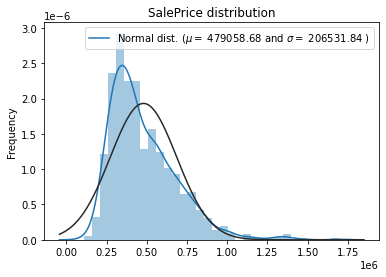

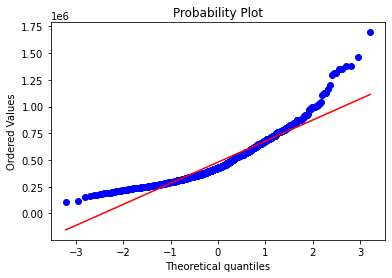

In [8]:
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew 

sns.distplot(y_train , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(y_train)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(y_train, plot=plt)
plt.show()

The distribution of the target variable is skewed. 

Perform log-transformation of the target variable in the training and test set.

c:\Users\nino\anaconda4\envs\myenv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)



 mu = 13.00 and sigma = 0.40



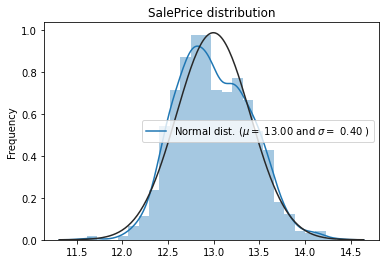

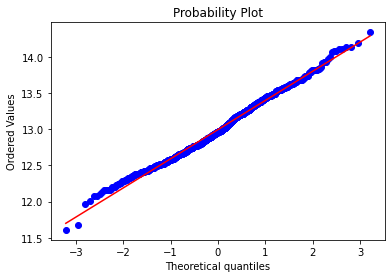

In [9]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
y_train = np.log1p(y_train)

#Check the new distribution 
sns.distplot(y_train , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(y_train)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(y_train, plot=plt)
plt.show()

c:\Users\nino\anaconda4\envs\myenv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)



 mu = 12.96 and sigma = 0.33



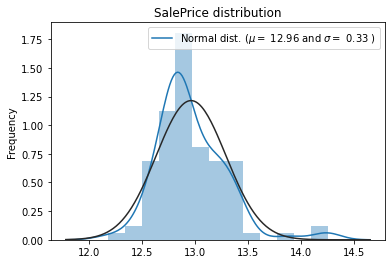

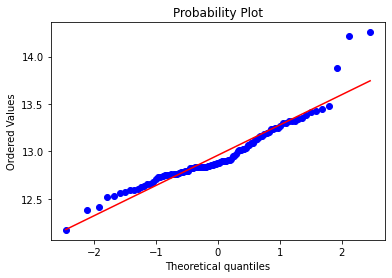

In [10]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
y_test = np.log1p(y_test)

#Check the new distribution 
sns.distplot(y_test , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(y_test)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(y_test, plot=plt)
plt.show()

## Modeling with network embedding - GLACE

In [11]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X_train, y_train)


LinearRegression()

I should check for the following conditions to check what isd going wrong with the prediction of the models:
1) Class imbalance, uneven distirbution. Need to plot the distribution and ptoentially nromalize it. -- Lognormalizing this does have a signifant increase in performance of the model too.
2) High non-linearitty, then i need to use another model to see if it has the same consequence -- IT SEEMS LIKE THIS WAS THE CASE!
3) Overfitting, seems weird. Could check by taking a larger dataset or using regularization.

In [12]:
linreg.predict(X_test)

array([12.6883545, 12.924438 , 12.843628 , 12.680176 , 12.80365  ,
       12.899963 , 13.142822 , 12.758972 , 13.031616 , 12.4646   ,
       12.789124 , 12.8302   , 12.790466 , 13.138367 , 12.35437  ,
       13.177856 , 12.942444 , 12.987427 , 12.756653 , 12.761108 ,
       12.704529 , 12.731506 , 12.837097 , 12.945679 , 13.780701 ,
       12.776367 , 13.237915 , 12.721619 , 12.95874  , 12.442261 ,
       12.833008 , 12.882751 , 12.944458 , 12.81897  , 12.837891 ,
       13.162659 , 12.241089 , 12.933044 , 13.135071 , 13.302856 ,
       12.802368 , 12.612976 , 12.707397 , 12.869263 , 12.970276 ,
       12.444336 , 12.747314 , 12.783386 , 12.742126 , 12.561401 ,
       12.966064 , 12.679321 , 13.199097 , 13.126587 , 12.6154785,
       12.839844 , 13.191895 , 12.536194 , 13.240601 , 13.078674 ,
       13.148193 , 13.293823 , 12.815369 , 13.184631 , 13.750122 ,
       12.727783 , 12.899902 , 12.816467 , 13.093994 , 12.906982 ,
       12.756348 , 13.642212 , 12.783691 , 12.767151 , 12.8600

In [13]:
linreg.score(X_test, y_test)

0.7890585353155848

In [14]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(linreg, X_train, y_train, cv=5)
scores.mean()

0.7533424059750905

In [15]:
XGBR = XGBRegressor()
XGBR.fit(X_train, y_train)
predictions = XGBR.predict(X_test)
XGBR.score(X_test, y_test)

0.6044354042058658

In [16]:
scores = cross_val_score(XGBR, X_train, y_train, cv=5)
scores.mean() # Need to check if this is normal without hyperparameter tuning etc. Check this in contrast to using a classical approach to estimating the model performance.
# Note also that this is a very small dataset of 1000 instances, it has trained on approx 800 and tests on 200, so it is somewhat normal that the score is low.

0.6640312788220826

In [17]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [18]:
rf.score(X_test, y_test)

0.6248877819414376

In [31]:
scores = cross_val_score(rf, X_train, y_train, cv=5)
scores.mean()

0.6820752678748729

In [27]:
mse = mean_squared_error(y_test, y_pred)
mse

107.22547883637122

## Modelling without network embedding - raw features

Feature engineering is not included yet with regards to geospatial information like amount of houses in certain proximity.
(Currently using the dataset without zipcode)

In [19]:
base_df = pd.read_csv("BaseKC_data.csv")
base_df 

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,year,month,day,index
0,3793500160,323000.0,0.090909,0.411765,0.309917,0.009483,0.4,0.0,0.0,0.50,...,0.895652,0.0,47.3684,-122.031,0.497076,0.028580,1.0,0.181818,0.366667,9
1,6865200140,485000.0,0.121212,0.058824,0.250000,0.005856,0.2,0.0,0.0,0.75,...,0.139130,0.0,47.6648,-122.343,0.269006,0.014299,0.0,0.363636,0.933333,17
2,5416510140,360000.0,0.121212,0.411765,0.411157,0.006979,0.4,0.0,0.0,0.50,...,0.913043,0.0,47.3608,-122.036,0.505848,0.017356,0.0,0.545455,0.300000,73
3,5104520400,390000.0,0.090909,0.411765,0.404959,0.007140,0.4,0.0,0.0,0.50,...,0.895652,0.0,47.3512,-122.008,0.485380,0.018941,0.0,1.000000,0.033333,80
4,7437100340,360000.0,0.121212,0.411765,0.311983,0.008406,0.4,0.0,0.0,0.50,...,0.800000,0.0,47.3490,-122.031,0.345029,0.023492,0.0,1.000000,0.700000,81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1187,1931300090,610950.0,0.090909,0.529412,0.266529,0.001475,0.8,0.0,0.0,0.50,...,0.991304,0.0,47.6572,-122.346,0.277778,0.016483,0.0,0.363636,0.200000,21574
1188,7570050450,347500.0,0.090909,0.411765,0.444215,0.006594,0.4,0.0,0.0,0.50,...,0.956522,0.0,47.3452,-122.022,0.540936,0.015482,0.0,0.727273,0.300000,21589
1189,1931300412,475000.0,0.090909,0.352941,0.165289,0.000881,0.8,0.0,0.0,0.50,...,0.939130,0.0,47.6542,-122.346,0.143275,0.000865,1.0,0.272727,0.500000,21592
1190,1972201967,520000.0,0.060606,0.352941,0.235537,0.000530,0.8,0.0,0.0,0.50,...,0.921739,0.0,47.6533,-122.346,0.245614,0.001118,0.0,0.818182,1.000000,21595


In [23]:
from sklearn.model_selection import train_test_split
X = base_df.drop(["price"], axis=1)
y = base_df["price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X_train, y_train)
linreg.predict(X_test)
linreg.score(X_test, y_test)


0.6782527502060054

In [25]:
XGBR = XGBRegressor()
XGBR.fit(X_train, y_train)
predictions = XGBR.predict(X_test)
XGBR.score(X_test, y_test)

0.7563763782115649

In [39]:
from sklearn.model_selection import cross_val_score
for model in [linreg, XGBR]:
    scores = cross_val_score(model, X_train, y_train, cv=5)
    print(model, scores.mean())

LinearRegression() 0.7143905047121325
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None) 0.7974539778845315


Predictions with log normalized target variables

In [74]:
y_train = np.log1p(y_train)
y_test = np.log1p(y_test)

In [75]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X_train, y_train)
linreg.predict(X_test)
linreg.score(X_test, y_test)

0.7112354480497862

In [76]:
XGBR = XGBRegressor()
XGBR.fit(X_train, y_train)
predictions = XGBR.predict(X_test)
XGBR.score(X_test, y_test)

0.7974338493242606

In [77]:
from sklearn.model_selection import cross_val_score
for model in [linreg, XGBR]:
    scores = cross_val_score(model, X_train, y_train, cv=5)
    print(model, scores.mean())

LinearRegression() 0.7869547369505678
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None) 0.8481229224833513


## RAW + GLACE embedding

In [50]:
ps = pd.read_pickle('GLACE/emb/Full_embedding.pkl')
labels = pd.read_csv("price_label_sample.csv")
base_df = pd.read_csv("BaseKC_data.csv")

In [32]:
len(ps["mu"])

2997

Convert from dictionary to numpy arrays

In [51]:
X_train =  np.array([np.array(ps['mu'][k]) for k in range(0, len(ps['mu']) - 600)])
X_test = np.array([np.array(ps['mu'][k]) for k in range(len(ps['mu']) - 600, len(ps['mu']))])

y_train =  np.array([np.array(labels['price'][k]) for k in range(0, len(labels['price']) - 600)])
y_test = np.array([np.array(labels['price'][k]) for k in range(len(labels['price']) - 600, len(labels['price']))])

In [34]:
X_train

array([[ 0.02312323, -0.1026051 , -0.02925652, ..., -0.08518298,
        -0.18056665, -0.21074598],
       [-0.04496492, -0.14741056,  0.08957804, ..., -0.08149321,
        -0.08269587, -0.26118588],
       [-0.01128495, -0.13480702,  0.01291583, ..., -0.08226939,
        -0.14577892, -0.2324684 ],
       ...,
       [-0.04037491, -0.16919231,  0.10053911, ..., -0.08555214,
        -0.07047603, -0.26937228],
       [ 0.03233286, -0.11651944, -0.08765791, ..., -0.0747516 ,
        -0.2264287 , -0.20446193],
       [ 0.00348785, -0.11637978,  0.00574327, ..., -0.09297414,
        -0.1466388 , -0.22999403]], dtype=float32)

Convert 2D numpy array to pandas dataframes

In [52]:
X_train = pd.DataFrame(X_train.tolist(), columns=["col_" + str(i) for i in range(X_train.shape[1])])
X_test = pd.DataFrame(X_test.tolist(), columns=["col_" + str(i) for i in range(X_test.shape[1])])

In [48]:
print("train shape: ", X_train.shape)
print("test shape: ", X_test.shape)
print("base_Df shape: ", base_df.shape)

train shape:  (2397, 64)
test shape:  (600, 64)
base_Df shape:  (2997, 23)


In [53]:
base_df_train = base_df.head(2397)
base_df_train.shape

(2397, 23)

In [54]:
base_df_test = base_df.tail(600)
base_df_test.reset_index(drop=True, inplace=True)
base_df_test.shape

(600, 23)

Concatenate the dataframe containing the values of the network embedding and the data from the raw dataframe - RAW + GLACE

In [55]:
X_train_concatenated = pd.concat([X_train, base_df_train], axis=1)

In [70]:
X_test_concatenated = pd.concat([X_test, base_df_test], axis=1)

In [84]:
X_train_concatenated.drop(["price"], inplace=True, axis=1)
X_test_concatenated.drop(["price"], inplace=True, axis=1)

KeyError: "['price'] not found in axis"

Model predictions of raw + GLACE

In [86]:
lr = LinearRegression()
lr.fit(X_train_concatenated, y_train)
lr.score(X_test_concatenated, y_test)

0.6329847154233685

In [87]:
from sklearn.model_selection import cross_val_score
XGBR = XGBRegressor()
scores = cross_val_score(XGBR, X_train_concatenated, y_train, cv=5)
scores.mean()

0.7970433119501832

In [90]:
from sklearn.model_selection import cross_val_score
XGBR = XGBRegressor()
scores = cross_val_score(XGBR, base_df_train, y_train, cv=5)
scores.mean()

0.7942039297044671

In [92]:
from sklearn.model_selection import cross_val_score
lr = LinearRegression()
scores = cross_val_score(lr, X_train_concatenated, y_train, cv=5)
scores.mean()

0.6940017659238373

In [91]:
from sklearn.model_selection import cross_val_score
lr = LinearRegression()
scores = cross_val_score(lr, base_df_train, y_train, cv=5)
scores.mean()

0.6769617247275944

In [93]:
from sklearn.linear_model import ElasticNet
el = ElasticNet()
scores = cross_val_score(el, X_train_concatenated, y_train, cv=5)
scores.mean()

0.1765312761857817

In [94]:
from sklearn.linear_model import ElasticNet
el = ElasticNet()
scores = cross_val_score(el, base_df_train, y_train, cv=5)
scores.mean()

0.139700086602927

In [95]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
scores = cross_val_score(rf, X_train_concatenated, y_train, cv=5)
scores.mean()

0.7765924305474534

In [96]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
scores = cross_val_score(rf, base_df_train, y_train, cv=5)
scores.mean()

0.7882613887596256